In [1]:
import pandas as pd
import numpy as np

import utils.print as print_f

from utils.coco_eval import get_eval_params_dict
from utils.engine import xami_train_one_epoch, xami_evaluate
from utils.plot import plot_loss, plot_train_val_evaluators, plot_evaluator
from utils.save import get_train_data

from models.setup import ModelSetup
from models.build import create_model_from_setup
from models.train import TrainingInfo
from utils.save import check_best, end_train
from data.load import get_datasets, get_dataloaders

from IPython.display import clear_output
from utils.eval import get_ar_ap
from utils.train import get_optimiser
from utils.init import reproducibility, clean_memory_get_device
from utils.constants import full_iou_thrs
from data.constants import DEFAULT_REFLACX_LABEL_COLS, XAMI_MIMIC_PATH
from  datetime import datetime


## Suppress the assignement warning from pandas.r
pd.options.mode.chained_assignment = None  # default='warn'

## Supress user warning
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

%matplotlib inline

In [2]:
### [TODO] ###

# [ ] -  

In [3]:
device = clean_memory_get_device()
reproducibility()

This notebook will running on device: [CUDA]


In [4]:
use_iobb = True
io_type_str = "IoBB" if use_iobb else "IoU"

all_model_setups = [
    # # [Work] - pretrained
    ModelSetup(
        name="pretrained_resnet50_without_clinical",
        use_clinical=False,
        use_custom_model=True,
        use_early_stop_model=True,
        backbone='resnet50',
        optimiser='sgd',
        lr=0.0005,
        pretrained=True,
        dataset_mode=  "unified",
        weight_decay=0.00005,
        record_training_performance=True,
    ),
    # # [Work] - pretrained
    ModelSetup(
        name="pretrained_resnet50_with_clinical",
        use_clinical=True,
        use_custom_model=True,
        use_early_stop_model=True,
        backbone='resnet50',
        optimiser='sgd',
        lr=0.0005,
        pretrained=True,
        dataset_mode=  "unified",
        weight_decay=0.00005,
        record_training_performance=True,
    ),
    # # [] - no pretrained.
    # ModelSetup(
    #     name="custom_without_clinical_no_pretrained",
    #     use_clinical=False,
    #     use_custom_model=True,
    #     use_early_stop_model=True,
    #     backbone='resnet50',
    #     optimiser='sgd',
    #     lr=0.0005,
    #     pretrained=False,
    #     dataset_mode=  "unified",
    #     weight_decay=0.00005,
    #     record_training_performance=True,
    # ),
    # # # [] - no pretrained.
    # ModelSetup(
    #     name="custom_with_clinical_no_pretrained",
    #     use_clinical=True,
    #     use_custom_model=True,
    #     use_early_stop_model=True,
    #     backbone='resnet50',
    #     optimiser='sgd',
    #     lr=0.0005,
    #     pretrained=False,
    #     dataset_mode=  "unified",
    #     weight_decay=0.00005,
    #     record_training_performance=True,
    # ),
    # [] - swin.
    # ModelSetup(
    #     name="custom_without_clinical_swim",
    #     use_clinical=False,
    #     use_custom_model=True,
    #     use_early_stop_model=True,
    #     backbone="swin",
    #     optimiser="adamw",
    #     lr=0.0001,
    #     pretrained=False,
    #     dataset_mode="unified",
    #     weight_decay=0.05,
    #     record_training_performance=False,
    # ),
    # # [] - swin.
    # ModelSetup(
    #     name="custom_with_clinical_swim",
    #     use_clinical=True,
    #     use_custom_model=True,
    #     use_early_stop_model=True,
    #     backbone="swin",
    #     optimiser="adamw",
    #     lr=0.0001,
    #     pretrained=False,
    #     dataset_mode="unified",
    #     weight_decay=0.05,
    #     record_training_performance=False,
    # ),
]

In [5]:
labels_cols = DEFAULT_REFLACX_LABEL_COLS
# iou_thrs = full_iou_thrs
iou_thrs = np.array([0.5])

# was 638 for all.

In [ ]:
# [0] - 43,943,923
# [1] - 62,334,753

In [6]:
num_epochs = 100
train_infos = []

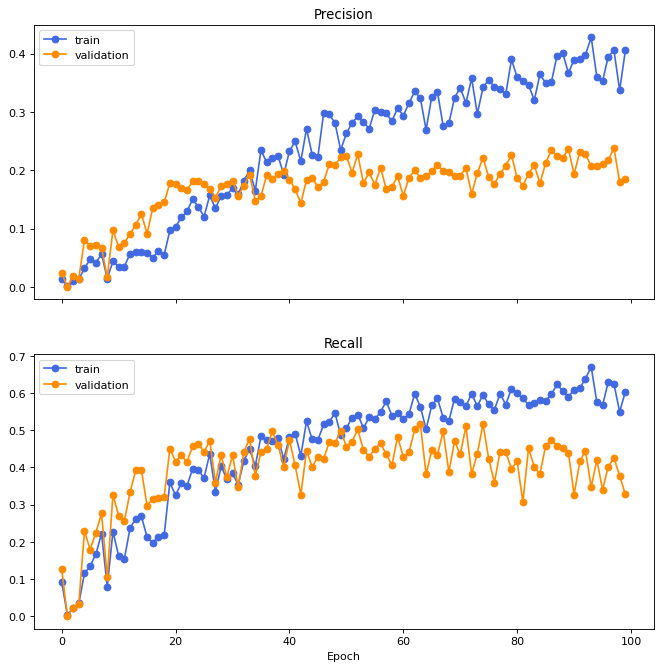

====================| Epoch [100] Done | It has took [621.38] min, Avg time: [372.83] sec/epoch | Estimate time for [100] epochs: [621.38] min |====================
====================| Training Done, start testing! | [100] Epochs Training time: [37283] seconds, Avg time / Epoch: [372.83] seconds====================
====================Best AP validation model has been saved to: [val_ar_0_4246_ap_0_2378_test_ar_0_4963_ap_0_1712_epoch98_WithClincal_04-19-2022 22-54-16_pretrained_resnet50_with_clinical]====================
====================Best AR validation model has been saved to: [val_ar_0_5164_ap_0_1869_test_ar_0_5086_ap_0_1718_epoch64_WithClincal_04-19-2022 19-33-35_pretrained_resnet50_with_clinical]====================
creating index...
index created!
Test:  [ 0/23]  eta: 0:00:29  model_time: 0.3271 (0.3271)  evaluator_time: 0.2461 (0.2461)  time: 1.3038  data: 0.4941  max mem: 3546
Test:  [22/23]  eta: 0:00:00  model_time: 0.1977 (0.1949)  evaluator_time: 0.1730 (0.1655)  time

In [7]:

for model_setup in all_model_setups:
    
    train_info = TrainingInfo(model_setup)

    ################ Datasets ################
    dataset_params_dict = {
        "XAMI_MIMIC_PATH": XAMI_MIMIC_PATH,
        "with_clinical": model_setup.use_clinical,
        "dataset_mode": model_setup.dataset_mode,
        "bbox_to_mask": True,
        "labels_cols": labels_cols,
    }

    detect_eval_dataset, train_dataset, val_dataset, test_dataset = get_datasets(
        dataset_params_dict=dataset_params_dict
    )

    train_dataloader, val_dataloader, test_dataloader = get_dataloaders(
        train_dataset, val_dataset, test_dataset, batch_size=4
    )

    model = create_model_from_setup(
        labels_cols,
        model_setup,
        image_size=512,
        rpn_nms_thresh=0.3,
        box_detections_per_img=10,
        box_nms_thresh=0.2,
        rpn_score_thresh=0.0,
        box_score_thresh=0.05,
    )
    
    model.to(device)

    optimizer = get_optimiser(model, model_setup)

    lr_scheduler = None

    eval_params_dict = get_eval_params_dict(
        detect_eval_dataset, iou_thrs=iou_thrs, use_iobb=use_iobb,
    )

    ## Start the training from here.
    for e in range(num_epochs):

        print_f.print_title(f"Training model: [{model_setup.name}]")

        train_info.epoch = e + 1

        ###### Perform training and show the training result here ######
        model.train()

        train_loger = xami_train_one_epoch(
            model, optimizer, train_dataloader, device, train_info.epoch, print_freq=10,
        )

        train_info.train_data.append(get_train_data(train_loger))

        plot_loss(train_info.train_data)
        ################################################################

        ### update the learning rate
        if not lr_scheduler is None:
            lr_scheduler.step()

        ####### Put the model into evaluation mode, start evaluating the current model #######
        model.eval()

        if model_setup.record_training_performance:
        ### evaluate on the validation dataset
            train_evaluator = xami_evaluate(
                model, train_dataloader, device=device, params_dict=eval_params_dict
            )
            train_info.train_evaluators.append(train_evaluator)

        val_evaluator = xami_evaluate(
            model, val_dataloader, device=device, params_dict=eval_params_dict
        )

        train_info.val_evaluators.append(val_evaluator)

        ## Clean everything before we show the evaluating result in this stage, so we can inspect the training progress.
        clear_output()

        if model_setup.record_training_performance:
            plot_train_val_evaluators(
                train_info.train_evaluators,
                train_info.val_evaluators,
                areaRng="all",
                iouThr=0.5,
                maxDets=10,
            )
        else:
            plot_evaluator(
                train_info.val_evaluators, iouThr=0.5, areaRng="all", maxDets=10,
            )

        current_time = datetime.now()
        sec_took = (current_time - train_info.start_t).seconds
        speed =  sec_took/train_info.epoch
        
        print_f.print_title(
            f"| Epoch [{train_info.epoch}] Done | It has took [{sec_took/60:.2f}] min, Avg time: [{speed:.2f}] sec/epoch | Estimate time for [{num_epochs}] epochs: [{speed*num_epochs/60:.2f}] min |"
        )

        #######################################################################################

        if model_setup.use_early_stop_model:
            val_ar, val_ap, train_info = check_best(
                device=device,
                eval_params_dict=eval_params_dict,
                train_info=train_info,
                model=model,
                optim=optimizer,
                test_dataloader=test_dataloader,
            )

    val_ar, val_ap = get_ar_ap(train_info.val_evaluators[-1])

    train_info = end_train(
        train_info=train_info,
        model=model,z
        optim=optimizer,
        eval_params_dict=eval_params_dict,
        last_val_ar=val_ar,
        last_val_ap=val_ap,
        test_dataloader=test_dataloader,
         device=device,
    )
    
    train_infos.append(train_info)


In [8]:
for train_info in train_infos:
    print(train_info)

========================================For Training [pretrained_resnet50_without_clinical]========================================
ModelSetup(use_clinical=False, use_custom_model=True, use_early_stop_model=True, name='pretrained_resnet50_without_clinical', best_ar_val_model_path=None, best_ap_val_model_path=None, final_model_path=None, backbone='resnet50', optimiser='sgd', lr=0.0005, weight_decay=5e-05, pretrained=True, record_training_performance=True, dataset_mode='unified')

Best AP validation model has been saved to: [val_ar_0_5272_ap_0_2396_test_ar_0_6170_ap_0_1962_epoch44_WithoutClincal_04-19-2022 07-35-55_pretrained_resnet50_without_clinical]
Best AR validation model has been saved to: [val_ar_0_5272_ap_0_2396_test_ar_0_6170_ap_0_1962_epoch44_WithoutClincal_04-19-2022 07-35-46_pretrained_resnet50_without_clinical]
The final model has been saved to: [val_ar_0_3257_ap_0_1868_test_ar_0_4210_ap_0_1598_epoch100_WithoutClincal_04-19-2022 12-44-29_pretrained_resnet50_without_clinical]

In [9]:
train_info.model_setup

ModelSetup(use_clinical=True, use_custom_model=True, use_early_stop_model=True, name='pretrained_resnet50_with_clinical', best_ar_val_model_path=None, best_ap_val_model_path=None, final_model_path=None, backbone='resnet50', optimiser='sgd', lr=0.0005, weight_decay=5e-05, pretrained=True, record_training_performance=True, dataset_mode='unified')

In [10]:

# ========================================For Training [custom_without_clinical_swim]========================================
# ModelSetup(use_clinical=False, use_custom_model=True, use_early_stop_model=True, name='custom_without_clinical_swim', best_ar_val_model_path=None, best_ap_val_model_path=None, final_model_path=None, backbone='swin', optimiser='adamw', lr=0.0001, weight_decay=0.05, pretrained=False, record_training_performance=False, dataset_mode='unified')
# ===========================================================================================================================

# Best AP validation model has been saved to: [val_ar_0_5307_ap_0_2054_test_ar_0_5321_ap_0_1726_epoch87_WithoutClincal_04-17-2022 06-51-10_custom_without_clinical_swim]
# Best AR validation model has been saved to: [val_ar_0_5313_ap_0_1540_test_ar_0_5906_ap_0_1486_epoch59_WithoutClincal_04-17-2022 05-48-30_custom_without_clinical_swim]
# The final model has been saved to: [val_ar_0_2175_ap_0_1390_test_ar_0_2231_ap_0_0901_epoch200_WithoutClincal_04-17-2022 10-49-59_custom_without_clinical_swim]

# ===========================================================================================================================
# ========================================For Training [custom_with_clinical_swim]========================================
# ModelSetup(use_clinical=True, use_custom_model=True, use_early_stop_model=True, name='custom_with_clinical_swim', best_ar_val_model_path=None, best_ap_val_model_path=None, final_model_path=None, backbone='swin', optimiser='adamw', lr=0.0001, weight_decay=0.05, pretrained=False, record_training_performance=False, dataset_mode='unified')
# ========================================================================================================================

# Best AP validation model has been saved to: [val_ar_0_5081_ap_0_2210_test_ar_0_5392_ap_0_1725_epoch95_WithClincal_04-17-2022 15-26-02_custom_with_clinical_swim]
# Best AR validation model has been saved to: [val_ar_0_5377_ap_0_1821_test_ar_0_4561_ap_0_1193_epoch67_WithClincal_04-17-2022 14-02-28_custom_with_clinical_swim]
# The final model has been saved to: [val_ar_0_2752_ap_0_1293_test_ar_0_3391_ap_0_1097_epoch200_WithClincal_04-17-2022 20-31-24_custom_with_clinical_swim]

# ========================================================================================================================

In [11]:
# ResNet Result for 100 epochs.
# ========================================For Training [custom_without_clinical_no_pretrained]========================================
# ModelSetup(use_clinical=False, use_custom_model=True, use_early_stop_model=True, name='custom_without_clinical_no_pretrained', best_ar_val_model_path=None, best_ap_val_model_path=None, final_model_path=None, backbone='resnet50', optimiser='sgd', lr=0.0005, weight_decay=5e-05, pretrained=False, record_training_performance=True, dataset_mode='unified')
# ========================================
# Best AR validation model has been saved to: [val_ar_0_5512_ap_0_2962_test_ar_0_5999_ap_0_2319_epoch93_WithoutClincal_04-12-2022 09-15-13_custom_without_clinical_no_pretrained]
# Best AP validation model has been saved to: [val_ar_0_5512_ap_0_2962_test_ar_0_5999_ap_0_2319_epoch93_WithoutClincal_04-12-2022 09-15-28_custom_without_clinical_no_pretrained]
# The final model has been saved to: [val_ar_0_4523_ap_0_2372_test_ar_0_5141_ap_0_2213_epoch100_WithoutClincal_04-12-2022 09-53-17_custom_without_clinical_no_pretrained]
# ========================================For Training [custom_with_clinical_no_pretrained]========================================
# ModelSetup(use_clinical=True, use_custom_model=True, use_early_stop_model=True, name='custom_with_clinical_no_pretrained', best_ar_val_model_path=None, best_ap_val_model_path=None, final_model_path=None, backbone='resnet50', optimiser='sgd', lr=0.0005, weight_decay=5e-05, pretrained=False, record_training_performance=True, dataset_mode='unified')
# ========================================
# Best AR validation model has been saved to: [val_ar_0_5056_ap_0_2360_test_ar_0_5891_ap_0_2176_epoch90_WithClincal_04-12-2022 18-38-40_custom_with_clinical_no_pretrained]
# Best AP validation model has been saved to: [val_ar_0_4589_ap_0_2492_test_ar_0_5737_ap_0_2272_epoch78_WithClincal_04-12-2022 17-26-34_custom_with_clinical_no_pretrained]
# The final model has been saved to: [val_ar_0_3470_ap_0_1944_test_ar_0_4186_ap_0_2042_epoch100_WithClincal_04-12-2022 19-38-09_custom_with_clinical_no_pretrained]

In [12]:
# Swin result. (of of them is broken.)
# ========================================For Training [custom_without_clinical_swim]========================================
# ModelSetup(use_clinical=False, use_custom_model=True, use_early_stop_model=True, name='custom_without_clinical_swim', best_ar_val_model_path=None, best_ap_val_model_path=None, final_model_path=None, backbone='swin', optimiser='adamw', lr=0.0001, weight_decay=5e-05, pretrained=False, record_training_performance=True, dataset_mode='unified')
# ========================================
# Best AR validation model has been saved to: [val_ar_0_5338_ap_0_1657_test_ar_0_5228_ap_0_1454_epoch49_WithoutClincal_04-15-2022 10-08-43_custom_without_clinical_swim]
# Best AP validation model has been saved to: [val_ar_0_4055_ap_0_2096_test_ar_0_4849_ap_0_1451_epoch94_WithoutClincal_04-15-2022 14-48-57_custom_without_clinical_swim]
# The final model has been saved to: [val_ar_0_2245_ap_0_1203_test_ar_0_2234_ap_0_0908_epoch200_WithoutClincal_04-16-2022 00-44-53_custom_without_clinical_swim]
# ========================================For Training [custom_with_clinical_swim]========================================
# ModelSetup(use_clinical=True, use_custom_model=True, use_early_stop_model=True, name='custom_with_clinical_swim', best_ar_val_model_path=None, best_ap_val_model_path=None, final_model_path=None, backbone='swin', optimiser='adamw', lr=0.0001, weight_decay=5e-05, pretrained=False, record_training_performance=True, dataset_mode='unified')
# ========================================
# Best AR validation model has been saved to: [val_ar_0_5038_ap_0_1500_test_ar_0_5308_ap_0_1325_epoch75_WithClincal_04-16-2022 09-55-55_custom_with_clinical_swim]
# Best AP validation model has been saved to: [val_ar_0_4485_ap_0_2138_test_ar_0_5002_ap_0_1346_epoch84_WithClincal_04-16-2022 11-10-33_custom_with_clinical_swim]
# The final model has been saved to: [val_ar_0_0727_ap_0_0008_test_ar_0_1429_ap_0_0030_epoch183_WithClincal_04-17-2022 03-16-37_custom_with_clinical_swim]

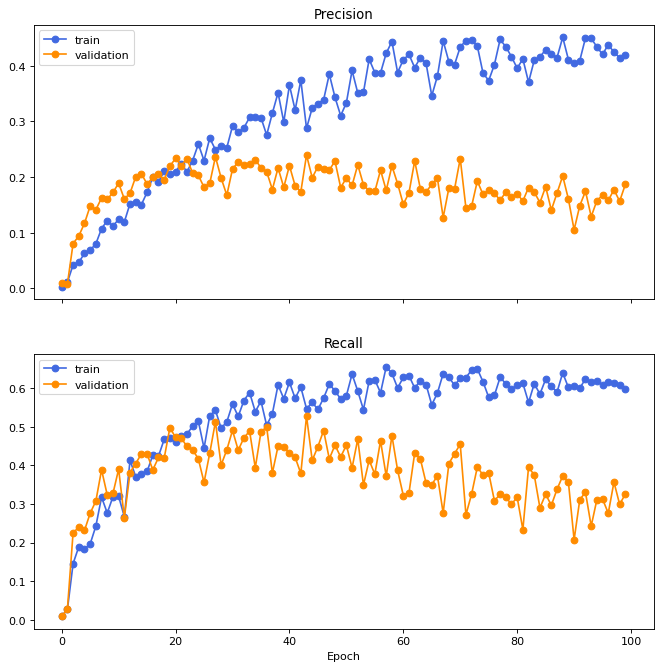

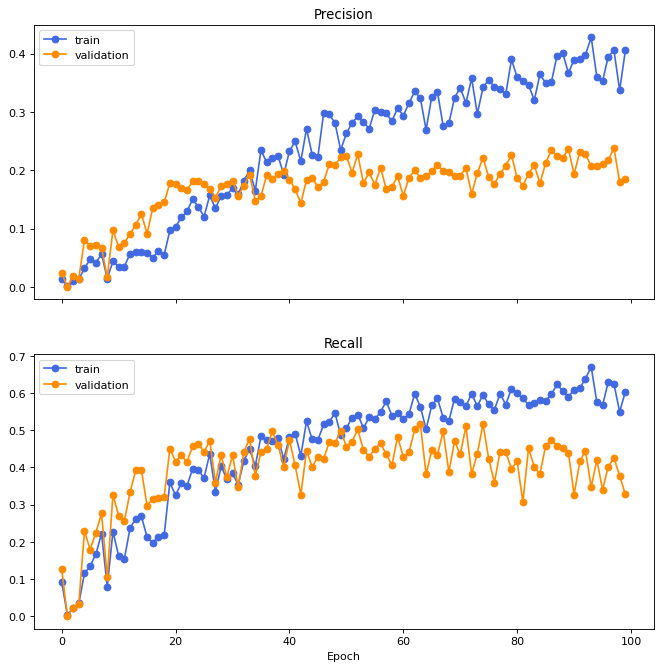

In [13]:
for idx, train_info in enumerate(train_infos):
    plot_train_val_evaluators(
        train_info.train_evaluators,
        train_info.val_evaluators,
        areaRng="all",
        iouThr=0.5,
        maxDets=10,
    )

# [Findings]: 
# 1. The model without clinical data seems converge faster.

In [14]:
# for train_info in train_infos:
#     print("="*40 + f"For Training [{train_info.model_setup.name}]" + "="*40)
#     print(train_info.model_setup)
#     print("="*40)  
#     print(f"Best AR validation model has been saved to: [{train_info.best_ar_val_model_path}]")
#     print(f"Best AP validation model has been saved to: [{train_info.best_ap_val_model_path}]")
#     print(f"The final model has been saved to: [{train_info.final_model_path}]")


In [15]:
# ========================================For Training [custom_without_clinical_pretrained]========================================
# ModelSetup(use_clinical=False, use_custom_model=True, use_early_stop_model=True, name='custom_without_clinical_pretrained', best_ar_val_model_path=None, best_ap_val_model_path=None, final_model_path=None, backbone='resnet50', optimiser='sgd', lr=0.0005, weight_decay=5e-05, pretrained=True, record_training_performance=False, dataset_mode='unified')
# ========================================
# Best AR validation model has been saved to: [val_ar_0_5181_ap_0_2127_test_ar_0_5659_ap_0_2037_epoch36_WithoutClincal_04-10-2022 08-07-20_custom_without_clinical_pretrained]
# Best AP validation model has been saved to: [val_ar_0_4635_ap_0_2291_test_ar_0_5178_ap_0_1937_epoch17_WithoutClincal_04-10-2022 07-30-34_custom_without_clinical_pretrained]
# The final model has been saved to: [val_ar_0_4279_ap_0_2052_test_ar_0_4103_ap_0_1757_epoch50_WithoutClincal_04-10-2022 08-34-20_custom_without_clinical_pretrained]
# ========================================For Training [custom_with_clinical_pretrained]========================================
# ModelSetup(use_clinical=True, use_custom_model=True, use_early_stop_model=True, name='custom_with_clinical_pretrained', best_ar_val_model_path=None, best_ap_val_model_path=None, final_model_path=None, backbone='resnet50', optimiser='sgd', lr=0.0005, weight_decay=5e-05, pretrained=True, record_training_performance=False, dataset_mode='unified')
# ========================================
# Best AR validation model has been saved to: [val_ar_0_5171_ap_0_2336_test_ar_0_5267_ap_0_1545_epoch39_WithClincal_04-10-2022 10-15-22_custom_with_clinical_pretrained]
# Best AP validation model has been saved to: [val_ar_0_4581_ap_0_2496_test_ar_0_5533_ap_0_1655_epoch49_WithClincal_04-10-2022 10-38-54_custom_with_clinical_pretrained]
# The final model has been saved to: [val_ar_0_3912_ap_0_1756_test_ar_0_5129_ap_0_1736_epoch50_WithClincal_04-10-2022 10-41-48_custom_with_clinical_pretrained]
# ========================================For Training [custom_without_clinical_no_pretrained]========================================
# ModelSetup(use_clinical=False, use_custom_model=True, use_early_stop_model=True, name='custom_without_clinical_no_pretrained', best_ar_val_model_path=None, best_ap_val_model_path=None, final_model_path=None, backbone='resnet50', optimiser='sgd', lr=0.0005, weight_decay=5e-05, pretrained=False, record_training_performance=False, dataset_mode='unified')
# ========================================
# Best AR validation model has been saved to: [val_ar_0_4295_ap_0_1586_test_ar_0_4991_ap_0_2054_epoch39_WithoutClincal_04-10-2022 12-02-33_custom_without_clinical_no_pretrained]
# Best AP validation model has been saved to: [val_ar_0_4156_ap_0_1726_test_ar_0_5085_ap_0_1841_epoch40_WithoutClincal_04-10-2022 12-05-11_custom_without_clinical_no_pretrained]
# The final model has been saved to: [val_ar_0_2427_ap_0_1189_test_ar_0_3630_ap_0_1724_epoch50_WithoutClincal_04-10-2022 12-25-02_custom_without_clinical_no_pretrained]
# ========================================For Training [custom_with_clinical_no_pretrained]========================================
# ModelSetup(use_clinical=True, use_custom_model=True, use_early_stop_model=True, name='custom_with_clinical_no_pretrained', best_ar_val_model_path=None, best_ap_val_model_path=None, final_model_path=None, backbone='resnet50', optimiser='sgd', lr=0.0005, weight_decay=5e-05, pretrained=False, record_training_performance=False, dataset_mode='unified')
# ========================================
# Best AR validation model has been saved to: [val_ar_0_4338_ap_0_2249_test_ar_0_4445_ap_0_1816_epoch49_WithClincal_04-10-2022 14-24-02_custom_with_clinical_no_pretrained]
# Best AP validation model has been saved to: [val_ar_0_4338_ap_0_2249_test_ar_0_4445_ap_0_1816_epoch49_WithClincal_04-10-2022 14-24-04_custom_with_clinical_no_pretrained]
# The final model has been saved to: [val_ar_0_3519_ap_0_1750_test_ar_0_4113_ap_0_1602_epoch50_WithClincal_04-10-2022 14-27-02_custom_with_clinical_no_pretrained]
# ========================================For Training [custom_without_clinical_swim]========================================
# ModelSetup(use_clinical=False, use_custom_model=True, use_early_stop_model=True, name='custom_with_clinical_swim', best_ar_val_model_path=None, best_ap_val_model_path=None, final_model_path=None, backbone='swin', optimiser='adamw', lr=0.0001, weight_decay=5e-05, pretrained=False, record_training_performance=False, dataset_mode='unified')
# ========================================
# Best AR validation model has been saved to: [val_ar_0_4324_ap_0_1400_test_ar_0_4371_ap_0_1408_epoch45_WithoutClincal_04-10-2022 16-09-22_custom_with_clinical_swim]
# Best AP validation model has been saved to: [val_ar_0_3653_ap_0_1552_test_ar_0_3867_ap_0_1298_epoch29_WithoutClincal_04-10-2022 15-34-21_custom_with_clinical_swim]
# The final model has been saved to: [val_ar_0_3816_ap_0_1417_test_ar_0_3788_ap_0_1313_epoch50_WithoutClincal_04-10-2022 16-20-24_custom_with_clinical_swim]
# ========================================For Training [custom_with_clinical_swim]========================================
# ModelSetup(use_clinical=True, use_custom_model=True, use_early_stop_model=True, name='custom_with_clinical_swim', best_ar_val_model_path=None, best_ap_val_model_path=None, final_model_path=None, backbone='swin', optimiser='adamw', lr=0.0001, weight_decay=5e-05, pretrained=False, record_training_performance=False, dataset_mode='unified')
# ========================================
# Best AR validation model has been saved to: [val_ar_0_4182_ap_0_1406_test_ar_0_4256_ap_0_0967_epoch44_WithClincal_04-10-2022 18-17-49_custom_with_clinical_swim]
# Best AP validation model has been saved to: [val_ar_0_3589_ap_0_1554_test_ar_0_4126_ap_0_1312_epoch41_WithClincal_04-10-2022 18-09-37_custom_with_clinical_swim]
# The final model has been saved to: [val_ar_0_3008_ap_0_0923_test_ar_0_3878_ap_0_1092_epoch50_WithClincal_04-10-2022 18-33-30_custom_with_clinical_swim]


In [16]:
# ========================================For Training [custom_with_clinical]========================================
# ModelSetup(use_clinical=True, use_custom_model=True, use_early_stop_model=True, name='custom_with_clinical', best_ar_val_model_path=None, best_ap_val_model_path=None, final_model_path=None, backbone='swin')
# ========================================
# Best AR validation model has been saved to: [val_ar_0_5702_ap_0_1778_test_ar_0_5586_ap_0_1920_epoch125_WithClincal_04-07-2022 16-10-43_custom_with_clinical]
# Best AP validation model has been saved to: [val_ar_0_5088_ap_0_2175_test_ar_0_5247_ap_0_1571_epoch85_WithClincal_04-07-2022 11-57-59_custom_with_clinical]
# The final model has been saved to: [val_ar_0_3453_ap_0_1556_test_ar_0_3459_ap_0_1416_epoch300_WithClincal_04-08-2022 09-41-51_custom_with_clinical]

In [17]:
# ========================================For Training [custom_with_clinical]========================================
# ModelSetup(use_clinical=True, use_custom_model=True, use_early_stop_model=True, name='custom_with_clinical', best_ar_val_model_path=None, best_ap_val_model_path=None, final_model_path=None, backbone='swin')
# ========================================
# Best AR validation model has been saved to: [val_ar_0_5112_ap_0_2027_test_ar_0_4902_ap_0_1178_epoch86_WithClincal_04-07-2022 12-05-12_custom_with_clinical]
# Best AP validation model has been saved to: [val_ar_0_5088_ap_0_2175_test_ar_0_5247_ap_0_1571_epoch85_WithClincal_04-07-2022 11-57-59_custom_with_clinical]
# The final model has been saved to: [val_ar_0_2673_ap_0_1166_test_ar_0_3118_ap_0_1119_epoch100_WithClincal_04-07-2022 13-31-10_custom_with_clinical]

## Model Paths 

In [18]:
model.dropout_rate

0

In [19]:
### Full training

# ========================================For Training [original]========================================
# ModelSetup(use_clinical=False, use_custom_model=False, use_early_stop_model=True, name='original', best_ar_val_model_path=None, best_ap_val_model_path=None, final_model_path=None)
# ========================================
# Best AR validation model has been saved to: [val_ar_0_5230_ap_0_2576_test_ar_0_5678_ap_0_2546_epoch28_WithoutClincal_03-28-2022 06-56-13_original] *
# Best AP validation model has been saved to: [val_ar_0_4828_ap_0_2977_test_ar_0_5052_ap_0_2331_epoch20_WithoutClincal_03-28-2022 06-34-49_original]
# The final model has been saved to: [val_ar_0_4463_ap_0_2006_test_ar_0_4904_ap_0_2154_epoch50_WithoutClincal_03-28-2022 07-51-38_original]


# ========================================For Training [custom_without_clinical]========================================
# ModelSetup(use_clinical=False, use_custom_model=True, use_early_stop_model=True, name='custom_without_clinical', best_ar_val_model_path=None, best_ap_val_model_path=None, final_model_path=None)
# ========================================
# Best AR validation model has been saved to: [val_ar_0_4941_ap_0_2401_test_ar_0_5191_ap_0_2368_epoch11_WithoutClincal_03-28-2022 08-19-58_custom_without_clinical]
# Best AP validation model has been saved to: [val_ar_0_4575_ap_0_2689_test_ar_0_4953_ap_0_2561_epoch40_WithoutClincal_03-28-2022 09-15-40_custom_without_clinical] *
# The final model has been saved to: [val_ar_0_3348_ap_0_2367_test_ar_0_3721_ap_0_1814_epoch50_WithoutClincal_03-28-2022 09-34-36_custom_without_clinical]

### Dropout = (0.0)
# ========================================For Training [custom_with_clinical]========================================
# ModelSetup(use_clinical=True, use_custom_model=True, use_early_stop_model=True, name='custom_with_clinical', best_ar_val_model_path=None, best_ap_val_model_path=None, final_model_path=None)
# ========================================
# Best AR validation model has been saved to: [val_ar_0_5363_ap_0_2963_test_ar_0_5893_ap_0_2305_epoch36_WithClincal_03-28-2022 20-06-43_custom_with_clinical]*
# Best AP validation model has been saved to: [val_ar_0_5363_ap_0_2963_test_ar_0_5893_ap_0_2305_epoch36_WithClincal_03-28-2022 20-06-44_custom_with_clinical]
# The final model has been saved to: [val_ar_0_3798_ap_0_2078_test_ar_0_5041_ap_0_2052_epoch50_WithClincal_03-28-2022 20-36-05_custom_with_clinical]


### Dropout = (0.2)
# ========================================For Training [custom_with_clinical]========================================
# ModelSetup(use_clinical=True, use_custom_model=True, use_early_stop_model=True, name='custom_with_clinical', best_ar_val_model_path=None, best_ap_val_model_path=None, final_model_path=None)
# ========================================
# Best AR validation model has been saved to: [val_ar_0_5126_ap_0_2498_test_ar_0_5607_ap_0_2538_epoch18_WithClincal_03-28-2022 10-18-55_custom_with_clinical]*
# Best AP validation model has been saved to: [val_ar_0_5090_ap_0_2753_test_ar_0_5324_ap_0_2337_epoch32_WithClincal_03-28-2022 10-47-07_custom_with_clinical]
# The final model has been saved to: [val_ar_0_3097_ap_0_2025_test_ar_0_3521_ap_0_1591_epoch50_WithClincal_03-28-2022 11-22-58_custom_with_clinical]

### Dropout = (0.3)
# ========================================For Training [custom_with_clinical]========================================
# ModelSetup(use_clinical=True, use_custom_model=True, use_early_stop_model=True, name='custom_with_clinical', best_ar_val_model_path=None, best_ap_val_model_path=None, final_model_path=None)
# ========================================
# Best AR validation model has been saved to: [val_ar_0_5512_ap_0_2769_test_ar_0_4896_ap_0_1875_epoch48_WithClincal_03-28-2022 16-01-09_custom_with_clinical]
# Best AP validation model has been saved to: [val_ar_0_4631_ap_0_2860_test_ar_0_4462_ap_0_2249_epoch46_WithClincal_03-28-2022 15-56-11_custom_with_clinical]
# The final model has been saved to: [val_ar_0_3993_ap_0_2326_test_ar_0_4957_ap_0_2390_epoch50_WithClincal_03-28-2022 16-06-00_custom_with_clinical]*


### Dropout = (0.5)
# ========================================For Training [custom_with_clinical]========================================
# ModelSetup(use_clinical=True, use_custom_model=True, use_early_stop_model=True, name='custom_with_clinical', best_ar_val_model_path=None, best_ap_val_model_path=None, final_model_path=None)
# ========================================
# Best AR validation model has been saved to: [val_ar_0_5887_ap_0_2834_test_ar_0_5532_ap_0_1683_epoch34_WithClincal_03-28-2022 17-38-54_custom_with_clinical]
# Best AP validation model has been saved to: [val_ar_0_4955_ap_0_2942_test_ar_0_5449_ap_0_2566_epoch28_WithClincal_03-28-2022 17-25-34_custom_with_clinical]*
# The final model has been saved to: [val_ar_0_4053_ap_0_2322_test_ar_0_4286_ap_0_2031_epoch50_WithClincal_03-28-2022 18-12-35_custom_with_clinical]


# We need a enum function to load the model.

In [20]:
# 50 epoch
# val_ar_0_2370_ap_0_1530_test_ar_0_2396_ap_0_1236_epoch50_WithoutClincal_03-27-2022 02-41-12 (original)
# val_ar_0_2658_ap_0_1993_test_ar_0_2717_ap_0_1816_epoch50_WithoutClincal_03-27-2022 04-56-32(custom without clinical)
# val_ar_0_3839_ap_0_2107_test_ar_0_5359_ap_0_2286_epoch50_WithClincal_03-27-2022 06-59-57 (custom with clinical)

# Single 100 epoch
# val_ar_0_4986_ap_0_2911_test_ar_0_5360_ap_0_2273_epoch35_WithClincal_03-27-2022 16-00-27 (best)
# val_ar_0_1551_ap_0_1462_test_ar_0_2225_ap_0_1449_epoch100_WithClincal_03-27-2022 18-23-42(final)
